## Install and Import packages

In [2]:
# Install required packages

!pip install -q transformers
!pip install -q datasets
!pip install -q hazm
!pip install -q clean-text[gpl]
!pip install -q numpy
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 18.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of t

In [1]:
# Import required packages

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import hazm
from cleantext import clean

import plotly.express as px
import plotly.graph_objects as go

from tqdm.notebook import tqdm

import os
import re
import json
import copy
import collections

## Dataset

In [2]:
# Import the drive module from google.colab
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -rf /content/dataset

!unzip "/content/drive/MyDrive/NLP/Workshop-Bert Finetune/digimag.zip" -d /content/dataset/

Archive:  /content/drive/MyDrive/NLP/Workshop-Bert Finetune/digimag.zip
   creating: /content/dataset/digimag/
  inflating: /content/dataset/digimag/dev.csv  
  inflating: /content/dataset/digimag/train.csv  
  inflating: /content/dataset/digimag/test.csv  


In [4]:
!mv /content/dataset/digimag/dev.csv /content/dataset/digimag/test.csv /content/dataset/digimag/train.csv /content/dataset

!rm -rf /content/dataset/digimag

In [5]:
data = pd.read_csv('/content/dataset/train.csv', encoding='utf-8', delimiter='\t', on_bad_lines='skip')
data.drop(columns=['Unnamed: 0'], inplace=True)

data.head()

,content,label,label_id
0,نمایش تبلیغ در لاک‌اسکرین تعدادی از گوشی‌های ه...,علم و تکنولوژی,3
1,شکست Justice League در باکس آفیس پس از بازخورد...,هنر و سینما,5
2,کلاسیک بینی؛ همه چیز در یک شب اتفاق افتاد فیلم...,هنر و سینما,5
3,اپل دوباره سراغ رنده رفته چراکه آپگرید کردن سط...,علم و تکنولوژی,3
4,بررسی جزء به جزء بهترین بخش Ori and the Blind ...,بازی ویدیویی,0


In [6]:
# print data information
print('data information')
print(data.info(), '\n')

# print missing values information
print('missing values stats')
print(data.isnull().sum(), '\n')

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6896 entries, 0 to 6895
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   content   6896 non-null   object
 1   label     6896 non-null   object
 2   label_id  6896 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 161.8+ KB
None 

missing values stats
content     0
label       0
label_id    0
dtype: int64 



In [7]:
data = data.drop_duplicates(subset=['content'], keep='first')
data = data.reset_index(drop=True)
# print data information
print('data information')
print(data.info(), '\n')

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6896 entries, 0 to 6895
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   content   6896 non-null   object
 1   label     6896 non-null   object
 2   label_id  6896 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 161.8+ KB
None 



In [8]:
data.head()

,content,label,label_id
0,نمایش تبلیغ در لاک‌اسکرین تعدادی از گوشی‌های ه...,علم و تکنولوژی,3
1,شکست Justice League در باکس آفیس پس از بازخورد...,هنر و سینما,5
2,کلاسیک بینی؛ همه چیز در یک شب اتفاق افتاد فیلم...,هنر و سینما,5
3,اپل دوباره سراغ رنده رفته چراکه آپگرید کردن سط...,علم و تکنولوژی,3
4,بررسی جزء به جزء بهترین بخش Ori and the Blind ...,بازی ویدیویی,0


### Plot data distribution per label before normalization

In [9]:
unique_labels = list(sorted(data['label'].unique()))
print(f'We have #{len(unique_labels)}: {unique_labels}')

We have #7: ['بازی ویدیویی', 'راهنمای خرید', 'سلامت و زیبایی', 'علم و تکنولوژی', 'عمومی', 'هنر و سینما', 'کتاب و ادبیات']


In [10]:
fig = go.Figure()

groupby_rate = data.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of labels within contents',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

### Normalizaton per word count

In [11]:
# calculate the length of contents based on their words
data['content_len_by_words'] = data['content'].apply(lambda t: len(hazm.word_tokenize(t)))

In [12]:
min_max_len = data["content_len_by_words"].min(), data["content_len_by_words"].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Min: 24 	Max: 10500


In [13]:
def data_gl_than(data, less_than=100.0, greater_than=0.0, col='content_len_by_words'):
    data_length = data[col].values

    data_glt = sum([1 for length in data_length if greater_than < length <= less_than])

    data_glt_rate = (data_glt / len(data_length)) * 100

    print(f'Texts with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')

In [14]:
minlim, maxlim = 24, 2048

In [15]:
data_gl_than(data, maxlim, minlim)

Texts with word length of greater than 24 and less than 2048 includes 95.56% of the whole!


In [16]:
# remove comments with the length of fewer than three words
data['content_len_by_words'] = data['content_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else None)
data = data.dropna(subset=['content_len_by_words'])
data = data.reset_index(drop=True)

### Plot distribution of word counts

In [17]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=data['content_len_by_words']
))

fig.update_layout(
    title_text='Distribution of word counts within comments',
    xaxis_title_text='Word Count',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2
)

fig.show()

### Plot distribution of labels within contents

In [18]:
fig = go.Figure()

groupby_rate = data.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of labels within contents',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

### Normalize labels

In [19]:
def convert_label_to_others(label):
    if label in ['راهنمای خرید', 'عمومی', 'کتاب و ادبیات']:
        return 'غیره'
    return label

In [20]:
data['label'] = data['label'].apply(lambda l: convert_label_to_others(l))
labels = list(sorted(data['label'].unique()))
data.head()

,content,label,label_id,content_len_by_words
0,نمایش تبلیغ در لاک‌اسکرین تعدادی از گوشی‌های ه...,علم و تکنولوژی,3,238.0
1,شکست Justice League در باکس آفیس پس از بازخورد...,هنر و سینما,5,392.0
2,کلاسیک بینی؛ همه چیز در یک شب اتفاق افتاد فیلم...,هنر و سینما,5,683.0
3,اپل دوباره سراغ رنده رفته چراکه آپگرید کردن سط...,علم و تکنولوژی,3,1814.0
4,بررسی جزء به جزء بهترین بخش Ori and the Blind ...,بازی ویدیویی,0,1930.0


In [21]:
def fix_id_per_label(label_id):
    if label_id in [1,4,6]:
        return 4
    elif label_id == 0:
        return 0
    elif label_id == 2:
        return 1
    elif label_id == 3:
        return 2
    elif label_id == 5:
        return 3

In [22]:
data['label_id'] = data['label_id'].apply(lambda i: fix_id_per_label(i))
labels = list(sorted(data['label_id'].unique()))
data.head()

,content,label,label_id,content_len_by_words
0,نمایش تبلیغ در لاک‌اسکرین تعدادی از گوشی‌های ه...,علم و تکنولوژی,2,238.0
1,شکست Justice League در باکس آفیس پس از بازخورد...,هنر و سینما,3,392.0
2,کلاسیک بینی؛ همه چیز در یک شب اتفاق افتاد فیلم...,هنر و سینما,3,683.0
3,اپل دوباره سراغ رنده رفته چراکه آپگرید کردن سط...,علم و تکنولوژی,2,1814.0
4,بررسی جزء به جزء بهترین بخش Ori and the Blind ...,بازی ویدیویی,0,1930.0


In [23]:
unique_labels = data['label'].unique()

In [24]:
label2id = {
    'بازی ویدیویی': 0,
    'سلامت و زیبایی': 1,
    'علم و تکنولوژی': 2,
    'هنر و سینما': 3,
    'غیره': 4
}

id2label = {v: k for k, v in label2id.items()}

print("Labels to ids:")
for key in label2id:
    print(f"\t- id: {label2id[key]}")
    print(f'\t- label: {key}')

Labels to ids:
	- id: 0
	- label: بازی ویدیویی
	- id: 1
	- label: سلامت و زیبایی
	- id: 2
	- label: علم و تکنولوژی
	- id: 3
	- label: هنر و سینما
	- id: 4
	- label: غیره


In [25]:
fig = go.Figure()

groupby_rate = data.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of labels within contents after normalization of labels',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

### Balancing data and visualizing it

In [26]:
def balance_data(df, label_column):
    # Count the number of occurrences for each label
    label_counts = df[label_column].value_counts()

    # Minimum count of the least represented label
    min_count = label_counts.min()

    # Create a balanced DataFrame by sampling each label's data
    balanced_df = df.groupby(label_column).apply(lambda x: x.sample(min_count)).reset_index(drop=True)

    return balanced_df

In [27]:
balanced_data = balance_data(data, 'label')
balanced_data

,content,label,label_id,content_len_by_words
0,Alienware دو مانیتور مخصوص بازی معرفی کرد شرکت...,بازی ویدیویی,0,255.0
1,الکترونیک آرتز استودیوی سازنده‌ی تایتان‌فال را...,بازی ویدیویی,0,251.0
2,سازندگان League of Legends بازی جدیدی خواهند س...,بازی ویدیویی,0,271.0
3,آپدیت بعدی رینبو سیکس ۴۲ گیگابایت است قرار است...,بازی ویدیویی,0,338.0
4,برای تجربه The Division ۲ باید ۹۰ گیگ آپدیت دا...,بازی ویدیویی,0,311.0
...,...,...,...,...
1860,چرا مارول فیلم اسپایدرمن را برای سونی ساخت؟ شر...,هنر و سینما,3,473.0
1861,بازی‌های خوب پیمان معادی و حامد بهداد در روز س...,هنر و سینما,3,161.0
1862,جنگ ستارگان: خیزش اسکای‌واکر نتوانست منتقدان‌ ...,هنر و سینما,3,533.0
1863,با نامزدهای اسکار سال ۲۰۱۷ بیشتر آشنا شوید این...,هنر و سینما,3,160.0


In [28]:
fig = go.Figure()

groupby_rate = balanced_data.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of labels within contents after balancing of labels',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

### Remove addtional columns

In [29]:
balanced_data = balanced_data[['content', 'label_id']]
balanced_data = balanced_data.reset_index(drop=True)
print('Information of data:\n')
print(balanced_data.info())

Information of data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865 entries, 0 to 1864
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   content   1865 non-null   object
 1   label_id  1865 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 29.3+ KB
None


### Clean content column

In [30]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()

    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)

    # # normalizing
    # normalizer = hazm.Normalizer()
    # text = normalizer.normalize(text)

    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)

    text = wierd_pattern.sub(r'', text)

    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)

    return text

In [31]:
tqdm.pandas()

# cleaning contents
print("Applying preprocess cleaning on data")
balanced_data['cleaned_content'] = balanced_data['content'].progress_apply(cleaning)

# calculate the length of contents based on their words
print("\nFinding number of words in each content")
balanced_data['cleaned_content_len_by_words'] = balanced_data['cleaned_content'].progress_apply(lambda t: len(hazm.word_tokenize(t)))

# balanced_data contents with the length of fewer than three words
print("\nApplying preprocess trancation based on number of words")
data['cleaned_content_len_by_words'] = balanced_data['cleaned_content_len_by_words'].progress_apply(lambda len_t: len_t if minlim < len_t <= maxlim else None)
balanced_data = balanced_data.dropna(subset=['cleaned_content_len_by_words'])
balanced_data = balanced_data.reset_index(drop=True)

balanced_data.head()

Applying preprocess cleaning on data


  0%|          | 0/1865 [00:00<?, ?it/s]


Finding number of words in each content


  0%|          | 0/1865 [00:00<?, ?it/s]


Applying preprocess trancation based on number of words


  0%|          | 0/1865 [00:00<?, ?it/s]

,content,label_id,cleaned_content,cleaned_content_len_by_words
0,Alienware دو مانیتور مخصوص بازی معرفی کرد شرکت...,0,alienware دو مانیتور مخصوص بازی معرفی کرد شرکت...,255
1,الکترونیک آرتز استودیوی سازنده‌ی تایتان‌فال را...,0,الکترونیک آرتز استودیوی سازنده‌ی تایتان‌فال را...,251
2,سازندگان League of Legends بازی جدیدی خواهند س...,0,سازندگان league of legends بازی جدیدی خواهند س...,271
3,آپدیت بعدی رینبو سیکس ۴۲ گیگابایت است قرار است...,0,آپدیت بعدی رینبو سیکس ۴۲ گیگابایت است قرار است...,338
4,برای تجربه The Division ۲ باید ۹۰ گیگ آپدیت دا...,0,برای تجربه the division ۲ باید ۹۰ گیگ آپدیت دا...,311


In [32]:
labels = balanced_data['label_id'].unique()
print(f'We have #{len(labels)} labels: {labels}')

We have #5 labels: [0 1 2 4 3]


In [33]:
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_data.head()

,content,label_id,cleaned_content,cleaned_content_len_by_words
0,جان ویک به متال گیر سالید ۵ هم می‌آید کیانو ری...,0,جان ویک به متال گیر سالید ۵ هم می‌آید کیانو ری...,265
1,رضایت کولینا از عملکرد کمک داور ویدیویی در جام...,1,رضایت کولینا از عملکرد کمک داور ویدیویی در جام...,341
2,مانند بزرگان فکر کنیم؛ این هفته استیون هاوکینگ...,4,مانند بزرگان فکر کنیم؛ این هفته استیون هاوکینگ...,545
3,۱۰ کبوتر با کوله‌پشتی، آلودگی هوای لندن را گزا...,1,۱۰ کبوتر با کوله‌پشتی، آلودگی هوای لندن را گزا...,344
4,[اینفوگرافیک] چگونه هیچ‌وقت در مذاکره شکست نخو...,1,[اینفوگرافیک] چگونه هیچ‌وقت در مذاکره شکست نخو...,234


In [34]:
balanced_data = balanced_data[['cleaned_content', 'label_id']]
balanced_data.columns = ['text', 'label']
balanced_data.head()

,text,label
0,جان ویک به متال گیر سالید ۵ هم می‌آید کیانو ری...,0
1,رضایت کولینا از عملکرد کمک داور ویدیویی در جام...,1
2,مانند بزرگان فکر کنیم؛ این هفته استیون هاوکینگ...,4
3,۱۰ کبوتر با کوله‌پشتی، آلودگی هوای لندن را گزا...,1
4,[اینفوگرافیک] چگونه هیچ‌وقت در مذاکره شکست نخو...,1


### Summarize all tasks in preprocess function

In [35]:
def fix_labels(df):
    tqdm.pandas()
    new_df = df.copy()

    # cleaning contents
    print("\nMerge labels to a single column 'others'")
    new_df['label'] = new_df['label'].progress_apply(lambda l: convert_label_to_others(l))
    new_df['label_id'] = new_df['label_id'].progress_apply(lambda i: fix_id_per_label(i))

    new_df = new_df[['content', 'label_id']]
    new_df = new_df.reset_index(drop=True)
    return new_df


def fix_content(df):
    tqdm.pandas()
    new_df = df.copy()

    # cleaning contents
    print("\nApplying preprocess cleaning on data")
    new_df['cleaned_content'] = new_df['content'].progress_apply(cleaning)

    # calculate the length of contents based on their words
    print("\nFinding number of words in each content")
    new_df['cleaned_content_len_by_words'] = new_df['cleaned_content'].progress_apply(lambda t: len(hazm.word_tokenize(t)))

    # balanced_data contents with the length of fewer than three words
    print("\nApplying preprocess trancation based on number of words")
    data['cleaned_content_len_by_words'] = new_df['cleaned_content_len_by_words'].progress_apply(lambda len_t: len_t if minlim < len_t <= maxlim else None)

    new_df = new_df.dropna(subset=['cleaned_content_len_by_words'])
    new_df = new_df.reset_index(drop=True)

    return new_df


def preprocess(df):
    new_df = df.copy()
    new_df.drop(columns=['Unnamed: 0'], inplace=True)
    new_df = fix_labels(new_df)
    new_df = fix_content(new_df)
    new_df = new_df[['content', 'label_id']]
    new_df.columns = ['text', 'label']

    return new_df

### Train, Test and Dev datasets

In [36]:
train_df = balanced_data.copy()
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df.head()

test_df = pd.read_csv('/content/dataset/test.csv', encoding='utf-8', delimiter='\t', on_bad_lines='skip')
dev_df = pd.read_csv('/content/dataset/dev.csv', encoding='utf-8', delimiter='\t', on_bad_lines='skip')

test_df = preprocess(test_df)
dev_df = preprocess(dev_df)

train_df.head()


Merge labels to a single column 'others'


  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]


Applying preprocess cleaning on data


  0%|          | 0/852 [00:00<?, ?it/s]


Finding number of words in each content


  0%|          | 0/852 [00:00<?, ?it/s]


Applying preprocess trancation based on number of words


  0%|          | 0/852 [00:00<?, ?it/s]


Merge labels to a single column 'others'


  0%|          | 0/767 [00:00<?, ?it/s]

  0%|          | 0/767 [00:00<?, ?it/s]


Applying preprocess cleaning on data


  0%|          | 0/767 [00:00<?, ?it/s]


Finding number of words in each content


  0%|          | 0/767 [00:00<?, ?it/s]


Applying preprocess trancation based on number of words


  0%|          | 0/767 [00:00<?, ?it/s]

,text,label
0,انتقام‌ جویان: جنگ بی‌نهایت رکورد افتتاحیه تار...,3
1,سکوت طاهره و نامه‌های عاشقانه ساعدی دوم آذر ما...,4
2,چطور سیب زمینی شکم‌پر درست کنیم؟ سیب زمینی شکم...,1
3,کاهش قیمت ایکس‌باکس وان قبل از معرفی اسکورپیو ...,0
4,منتظر رونمایی از تلویزیون بدون حاشیه سامسونگ د...,2


In [37]:
x_train, y_train = train_df['text'].to_numpy(), train_df['label'].to_numpy()
x_dev, y_dev = dev_df['text'].to_numpy(), dev_df['label'].to_numpy()
x_test, y_test = test_df['text'].to_numpy(), test_df['label'].to_numpy()

print(train_df.shape)
print(dev_df.shape)
print(test_df.shape)

(1865, 2)
(767, 2)
(852, 2)


## Model - Prepration and Training

### Configuration

In [38]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from transformers import Trainer, TrainingArguments

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import torch
import torch.nn as nn
import torch.nn.functional as F

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [40]:
# general config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
DEV_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 3
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5

MODEL_NAME_OR_PATH = 'ViraIntelligentDataMining/AriaBERT'
OUTPUT_PATH = '/content/AriaBERT-classification/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [41]:
print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'بازی ویدیویی': 0, 'سلامت و زیبایی': 1, 'علم و تکنولوژی': 2, 'هنر و سینما': 3, 'غیره': 4}
id2label: {0: 'بازی ویدیویی', 1: 'سلامت و زیبایی', 2: 'علم و تکنولوژی', 3: 'هنر و سینما', 4: 'غیره'}


In [42]:
# setup the tokenizer and configuration

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = AutoConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

{
  "_name_or_path": "ViraIntelligentDataMining/AriaBERT",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "\u0628\u0627\u0632\u06cc \u0648\u06cc\u062f\u06cc\u0648\u06cc\u06cc",
    "1": "\u0633\u0644\u0627\u0645\u062a \u0648 \u0632\u06cc\u0628\u0627\u06cc\u06cc",
    "2": "\u0639\u0644\u0645 \u0648 \u062a\u06a9\u0646\u0648\u0644\u0648\u0698\u06cc",
    "3": "\u0647\u0646\u0631 \u0648 \u0633\u06cc\u0646\u0645\u0627",
    "4": "\u063a\u06cc\u0631\u0647"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "\u0628\u0627\u0632\u06cc \u0648\u06cc\u062f\u06cc\u0648\u06cc\u06cc": 0,
    "\u0633\u0644\u0627\u0645\u062a \u0648 \u0632\u06cc\u0628\u0627\u06cc\u06cc": 1,
    "\u0639\u0644\u0645 \u0648 \u062a\u06a9\u0646\u0648\u0644\u0648\u0698\u06cc": 2,
 

In [43]:
idx = np.random.randint(0, len(train_df))
sample_text = train_df.iloc[idx]['text']
sample_label = train_df.iloc[idx]['label']

print(f'Sample: \n{sample_text}\n{sample_label}')

Sample: 
برترین خبرهای دنیای دانش در سال ۹۴: پیشرفت‌های بزرگ در فناوری ویرایش ژنی کریسپر افراد زیادی در دنیا از بیماری‌های ژنتیکی صعب‌العلاج رنج می‌برند. هم اکنون روش‌هایی برای ژن درمانی وجود دارد. ولی ژن درمانی‌های مرسوم معمولا خیلی محدود و گران‌ قیمت هستند. اکنون پژوهشگران روی فناوری جدیدی برای ویرایش ژن‌ها به نام کریسپر (crispr) کار می‌کنند و سال گذشته دستاوردهای خیلی خوبی با آن بدست آمد. از جمله اینکه با انجام آن روی موشی که به دیستروفی ماهیچه‌ای دوشن مبتلا بود، توانستند وضعیت فلج موش را تا حدی بهبود بخشند. دیستروفی ماهیچه‌ای دوشن یک بیماری نادر است که باعث تحلیل و نابودی ماهیچه‌ها می‌شود. در موارد حاد بیمار پس از رسیدن به فلج ۹۶ درصد و ابتلا به مشکلات تنفسی، جان خود را از دست می‌دهد. معمولا مبتلایان به این بیماری تا سن ۲۰ یا ۳۰ سالگی بیشتر عمر نمی‌کنند. پژوهشگران با این فناوری می‌توانند dna معیوب کروموزوم‌هایی مشخص را از جا دربیاورند و با dna سالم جایگزین کنند. انتظار می‌رود که این فناوری یا فناوری‌های مشابه وقتی به بلوغ برسند، بتوانند بسیاری از بیماری‌های ژنتیکی را درمان کنند. خب

In [44]:
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'  Content: {sample_text}')
print(f'   Tokens: {tokenizer.convert_tokens_to_string(tokens)}')
print(f'Token IDs: {token_ids}')

  Content: برترین خبرهای دنیای دانش در سال ۹۴: پیشرفت‌های بزرگ در فناوری ویرایش ژنی کریسپر افراد زیادی در دنیا از بیماری‌های ژنتیکی صعب‌العلاج رنج می‌برند. هم اکنون روش‌هایی برای ژن درمانی وجود دارد. ولی ژن درمانی‌های مرسوم معمولا خیلی محدود و گران‌ قیمت هستند. اکنون پژوهشگران روی فناوری جدیدی برای ویرایش ژن‌ها به نام کریسپر (crispr) کار می‌کنند و سال گذشته دستاوردهای خیلی خوبی با آن بدست آمد. از جمله اینکه با انجام آن روی موشی که به دیستروفی ماهیچه‌ای دوشن مبتلا بود، توانستند وضعیت فلج موش را تا حدی بهبود بخشند. دیستروفی ماهیچه‌ای دوشن یک بیماری نادر است که باعث تحلیل و نابودی ماهیچه‌ها می‌شود. در موارد حاد بیمار پس از رسیدن به فلج ۹۶ درصد و ابتلا به مشکلات تنفسی، جان خود را از دست می‌دهد. معمولا مبتلایان به این بیماری تا سن ۲۰ یا ۳۰ سالگی بیشتر عمر نمی‌کنند. پژوهشگران با این فناوری می‌توانند dna معیوب کروموزوم‌هایی مشخص را از جا دربیاورند و با dna سالم جایگزین کنند. انتظار می‌رود که این فناوری یا فناوری‌های مشابه وقتی به بلوغ برسند، بتوانند بسیاری از بیماری‌های ژنتیکی را درمان کنند. 

### HuggingFace Dataset

In [49]:
from datasets import Dataset

In [50]:
train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)
test_dataset = Dataset.from_pandas(test_df)

In [51]:
# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding=True, truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
dev_dataset = dev_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1865 [00:00<?, ? examples/s]

Map:   0%|          | 0/767 [00:00<?, ? examples/s]

Map:   0%|          | 0/852 [00:00<?, ? examples/s]

In [52]:
train_dataset = train_dataset.remove_columns(['text'])
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

dev_dataset = dev_dataset.remove_columns(['text'])
dev_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

test_dataset = test_dataset.remove_columns(['text'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [53]:
train_dataset

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 1865
})

### Define model

### Define metrics



In [59]:
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro')
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'f1_micro': f1_micro,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
    }

### Define Training Arguments

In [60]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=DEV_BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    # logging_dir='./logs',
    # logging_steps=EEVERY_EPOCH,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss'
)

### Normal Model

#### Define model and trainer

In [54]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME_OR_PATH, num_labels=len(labels))

pytorch_model.bin:   0%|          | 0.00/529M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ViraIntelligentDataMining/AriaBERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics
)

#### Train and Evaluate

In [62]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Micro,Recall Micro,F1 Micro,Precision Macro,Recall Macro,F1 Macro
1,No log,0.635174,0.890482,0.908979,0.890482,0.896922,0.890482,0.890482,0.890482,0.828212,0.844130,0.829715
2,No log,0.330305,0.916558,0.921750,0.916558,0.918498,0.916558,0.916558,0.916558,0.859117,0.874882,0.865878
3,No log,0.275810,0.926988,0.929955,0.926988,0.927521,0.926988,0.926988,0.926988,0.880645,0.890957,0.885057


TrainOutput(global_step=351, training_loss=0.6503409361227964, metrics={'train_runtime': 631.6137, 'train_samples_per_second': 8.858, 'train_steps_per_second': 0.556, 'total_flos': 1472146007086080.0, 'train_loss': 0.6503409361227964, 'epoch': 3.0})

In [63]:
eval_results = trainer.evaluate(test_dataset)

In [66]:
eval_results

{'eval_loss': 0.31199514865875244,
 'eval_accuracy': 0.9072769953051644,
 'eval_precision_weighted': 0.9206164489394322,
 'eval_recall_weighted': 0.9072769953051644,
 'eval_f1_weighted': 0.9117001175108472,
 'eval_precision_micro': 0.9072769953051644,
 'eval_recall_micro': 0.9072769953051644,
 'eval_f1_micro': 0.9072769953051644,
 'eval_precision_macro': 0.8537783650915964,
 'eval_recall_macro': 0.8868482814849946,
 'eval_f1_macro': 0.8651752916502333,
 'eval_runtime': 25.38,
 'eval_samples_per_second': 33.57,
 'eval_steps_per_second': 2.128,
 'epoch': 3.0}

("Evaluation Results: {'eval_loss': 0.31199514865875244, 'eval_accuracy': "
 "0.9072769953051644, 'eval_precision_weighted': 0.9206164489394322, "
 "'eval_recall_weighted': 0.9072769953051644, 'eval_f1_weighted': "
 "0.9117001175108472, 'eval_precision_micro': 0.9072769953051644, "
 "'eval_recall_micro': 0.9072769953051644, 'eval_f1_micro': "
 "0.9072769953051644, 'eval_precision_macro': 0.8537783650915964, "
 "'eval_recall_macro': 0.8868482814849946, 'eval_f1_macro': "
 "0.8651752916502333, 'eval_runtime': 25.38, 'eval_samples_per_second': 33.57, "
 "'eval_steps_per_second': 2.128, 'epoch': 3.0}")




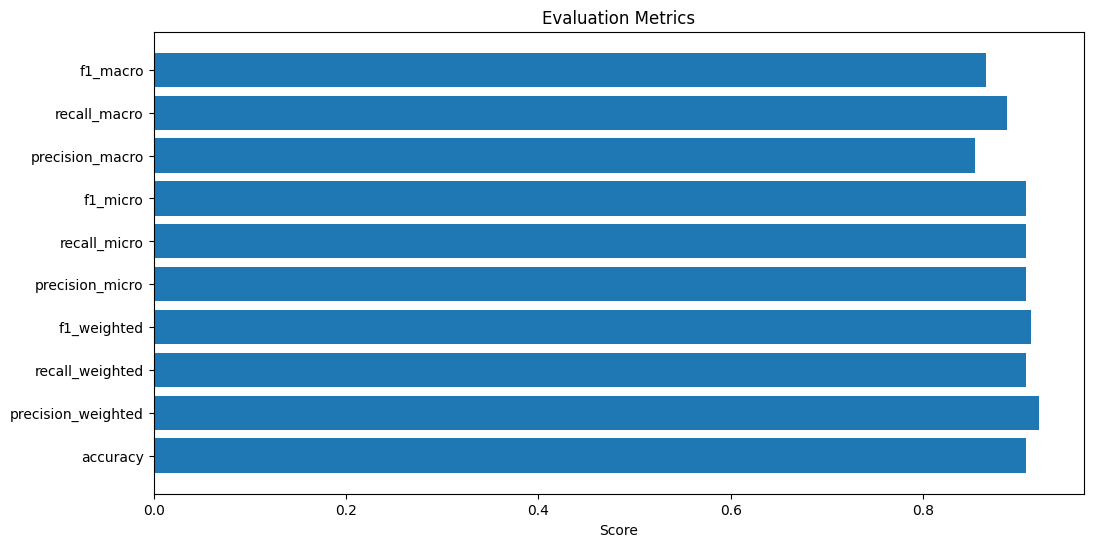

In [72]:
import matplotlib.pyplot as plt
from pprint import pprint

pprint(f"Evaluation Results: {eval_results}")
print('\n')

# Visualize the metrics
metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'precision_micro', 'recall_micro', 'f1_micro', 'precision_macro', 'recall_macro', 'f1_macro']
values = [eval_results['eval_' + metric] for metric in metrics]

plt.figure(figsize=(12, 6))
plt.barh(metrics, values)
plt.xlabel('Score')
plt.title('Evaluation Metrics')
plt.show()

### Freezed model

#### Define model and trainer

In [76]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME_OR_PATH, num_labels=len(labels))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ViraIntelligentDataMining/AriaBERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [78]:
# Freeze all layers except the classification layer
for param in model.base_model.parameters():
    param.requires_grad = False

In [79]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics
)

#### Train and Evaluate

In [80]:
# First Round
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Micro,Recall Micro,F1 Micro,Precision Macro,Recall Macro,F1 Macro
1,No log,1.550904,0.332464,0.690095,0.332464,0.302935,0.332464,0.332464,0.332464,0.580520,0.323583,0.267224
2,No log,1.415579,0.722295,0.796890,0.722295,0.746628,0.722295,0.722295,0.722295,0.698172,0.696238,0.669854
3,No log,1.185772,0.816167,0.844482,0.816167,0.819315,0.816167,0.816167,0.816167,0.771725,0.770543,0.755568


TrainOutput(global_step=351, training_loss=1.4683312744836183, metrics={'train_runtime': 281.194, 'train_samples_per_second': 19.897, 'train_steps_per_second': 1.248, 'total_flos': 1472146007086080.0, 'train_loss': 1.4683312744836183, 'epoch': 3.0})

In [81]:
# Second Round
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Micro,Recall Micro,F1 Micro,Precision Macro,Recall Macro,F1 Macro
1,No log,1.146292,0.822686,0.841774,0.822686,0.826679,0.822686,0.822686,0.822686,0.770464,0.774540,0.764524
2,No log,1.077857,0.809648,0.848378,0.809648,0.822671,0.809648,0.809648,0.809648,0.760606,0.779483,0.756461
3,No log,0.915426,0.843546,0.865296,0.843546,0.850427,0.843546,0.843546,0.843546,0.788661,0.805662,0.788805


TrainOutput(global_step=351, training_loss=1.1112916082398505, metrics={'train_runtime': 280.2714, 'train_samples_per_second': 19.963, 'train_steps_per_second': 1.252, 'total_flos': 1472146007086080.0, 'train_loss': 1.1112916082398505, 'epoch': 3.0})

In [82]:
eval_results = trainer.evaluate(test_dataset)

In [83]:
eval_results

{'eval_loss': 0.9223291873931885,
 'eval_accuracy': 0.8497652582159625,
 'eval_precision_weighted': 0.8790594757836979,
 'eval_recall_weighted': 0.8497652582159625,
 'eval_f1_weighted': 0.8588784874368637,
 'eval_precision_micro': 0.8497652582159625,
 'eval_recall_micro': 0.8497652582159625,
 'eval_f1_micro': 0.8497652582159625,
 'eval_precision_macro': 0.8025881897306801,
 'eval_recall_macro': 0.8276940444051692,
 'eval_f1_macro': 0.8021151335689496,
 'eval_runtime': 27.1542,
 'eval_samples_per_second': 31.376,
 'eval_steps_per_second': 1.989,
 'epoch': 3.0}

("Evaluation Results: {'eval_loss': 0.9223291873931885, 'eval_accuracy': "
 "0.8497652582159625, 'eval_precision_weighted': 0.8790594757836979, "
 "'eval_recall_weighted': 0.8497652582159625, 'eval_f1_weighted': "
 "0.8588784874368637, 'eval_precision_micro': 0.8497652582159625, "
 "'eval_recall_micro': 0.8497652582159625, 'eval_f1_micro': "
 "0.8497652582159625, 'eval_precision_macro': 0.8025881897306801, "
 "'eval_recall_macro': 0.8276940444051692, 'eval_f1_macro': "
 "0.8021151335689496, 'eval_runtime': 27.1542, 'eval_samples_per_second': "
 "31.376, 'eval_steps_per_second': 1.989, 'epoch': 3.0}")




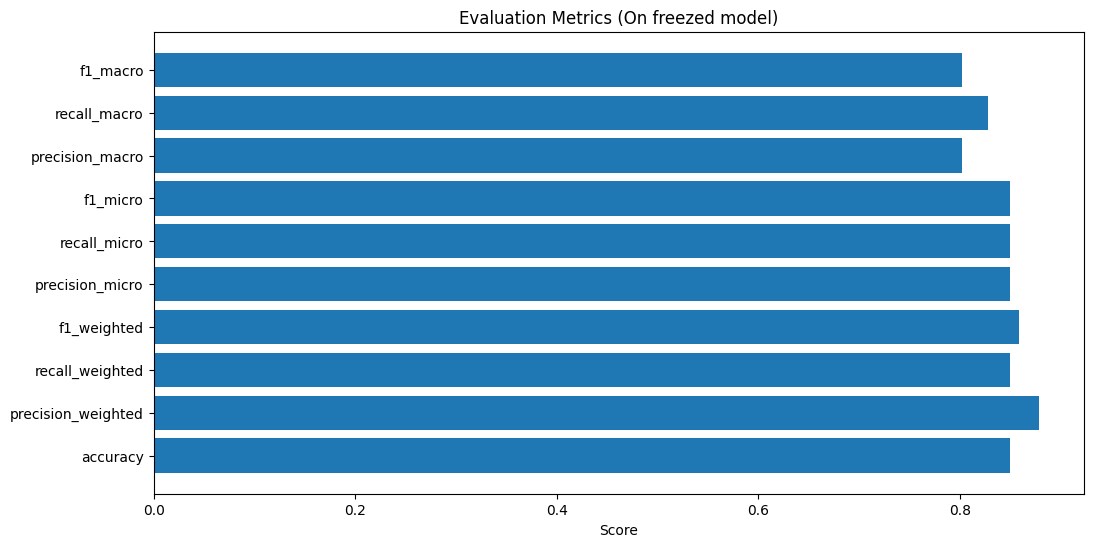

In [84]:
import matplotlib.pyplot as plt
from pprint import pprint

pprint(f"Evaluation Results: {eval_results}")
print('\n')

# Visualize the metrics
metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'precision_micro', 'recall_micro', 'f1_micro', 'precision_macro', 'recall_macro', 'f1_macro']
values = [eval_results['eval_' + metric] for metric in metrics]

plt.figure(figsize=(12, 6))
plt.barh(metrics, values)
plt.xlabel('Score')
plt.title('Evaluation Metrics (On freezed model)')
plt.show()